# Imports

In [1]:
import requests
import json
import folium
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from scipy.cluster.hierarchy import linkage, cut_tree
import matplotlib.pyplot as plt
import pandas as pd
import overpy
import os
import alphashape
import shapely
from matplotlib.patches import Polygon

# 1. Fetch Data

## 1.1.Data preprocessing

Using [Overpass API](https://wiki.openstreetmap.org/wiki/Overpass_API) to query locations that fulfill the given conditions. In this case, all [amenities](https://wiki.openstreetmap.org/wiki/Key:amenity), but all bus stations could be selected

In [2]:
api = overpy.Overpass()

location = "Granada"
road_distance = "2000"  # (m)

query = '''
[out:json];
area[name='''+ location + '''][admin_level=8]->.where;
node(area.where)[highway=bus_stop];
out body;
>;
out skel qt;'''


# Selecting ALL amenities
query = '''
[out:json];
area[name='''+ location + '''][admin_level=8]->.granada;
(
  node(area.granada)[amenity](37.120, -3.650, 37.300, -3.570);
);
out body;
>;
out skel qt;
'''

response = api.query(query)

In [3]:
# Preparing the dataframe [id,latitude,longitude]
df = pd.DataFrame(
    columns=["id","lat","lon"])

for node in response.get_nodes():
    # Adding all the position information of nodes
    new_row = pd.DataFrame(
        {"id": node.id,
         "lat": node.lat,
         "lon": node.lon},
         index=[0])

    df = pd.concat([df,new_row],axis=0)

# Formatted information into a DataFrame, only for convenience
df.reset_index(inplace=True, drop=True)
print(df)

               id         lat         lon
0        83533572  37.1868974  -3.6036270
1        88144037  37.1946846  -3.6228425
2       267489671  37.1868624  -3.5919396
3       290912866  37.2016761  -3.6155480
4       290969327  37.1741866  -3.5852181
...           ...         ...         ...
5275  12613072802  37.1736029  -3.5982325
5276  12613073001  37.1733682  -3.5975351
5277  12618982989  37.1780865  -3.6092263
5278  12624010583  37.1683284  -3.5973407
5279  12624036228  37.1653565  -3.5990484

[5280 rows x 3 columns]


Number of detected possible places: 5280


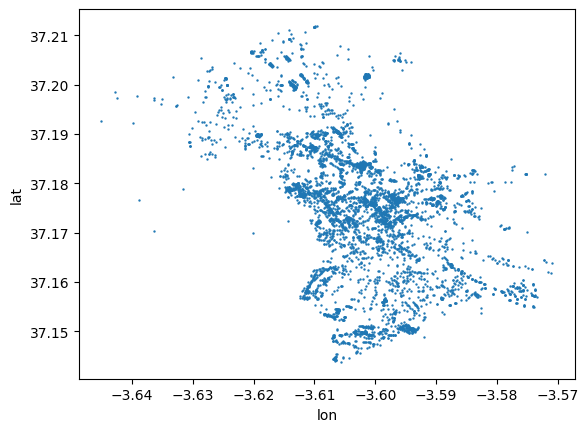

In [5]:
plt.scatter(x=df["lon"],y=df["lat"], s=0.5)
plt.xlabel("lon")
plt.ylabel("lat")
print("Number of detected possible places:", len(df.index))

## 1.2.Algorithm

Preprocessing: We will be using a clustering algorithm to hierarchically organize the bus stations. So the QUBO can be implemented layer by layer in the same hierarchical approach. This way, we exploit the fractal network that bus stops are

## 1.1.Data preprocessing

We create a class with all desirrd functionalities implemented and some functions that return distance matrices, etc.

In [60]:
from sklearn.metrics.pairwise import euclidean_distances
class linkageCut:
    def __init__(self, df):
        self.scaler = MinMaxScaler()
        self.data = self.scaler.fit_transform(df[['lon','lat']].values)
        self.data_lon_lat = df[['lon','lat']].values
        self.linkage_matrix = linkage(self.data, method='ward')
        self.tree_cut = cut_tree(self.linkage_matrix)
        
        self.top_down = None
        self.distance_matrix = None
        self.n_clusters = None
    def give_tree_cut(self):
        return self.tree_cut
    
    def __nunique(self, a, axis):
        ''' Count the number of unique elements in an array and axis'''
        return (np.diff(np.sort(a,axis=axis),axis=axis)!=0).sum(axis=axis)+1

    def __recursive_down(self, n_clusters, level, total_levels, mask):
        if len(str(level)) < total_levels:
            
            # Selecting specific parent cluster
            small_tree = self.tree_cut[mask]
            
            # Checking how many subclusters there are in the parent cluster for each step in
            # the clustering (ward) process
            small_tree_nclusters = self.__nunique(small_tree, axis=0)
            
            try:
                # This is the step where there are exactly n_clusters subclusters
                sub_tree_step = np.where(small_tree_nclusters == n_clusters)[0][-1]
            except:
                raise Exception("Some cluster cannot be further divided")
            # Now we truly have the subdivision
            
            counter = 1
            for sub_lbl in np.unique(small_tree[:,sub_tree_step]):
                # Now we prepare the mask for each subcluster and the recursion
                sub_data_mask = np.where(self.tree_cut[:, sub_tree_step] == sub_lbl)[0]
                write = self.__recursive_down( 
                                   n_clusters, int(str(level) + str(counter)), total_levels,
                                   sub_data_mask)
                if write == None:
                    write = str(level) + str(counter)
                self.top_down[sub_data_mask, len(str(level))] = int(write)
                counter+=1
                
            return None
        else:
            return level
        
    def top_down_view_recur(self, n_clusters, levels=1):
        ''' Constructs a top down view in which each cluster is
        subsequently divided in 'n_clusters'. This process 
        is iterated 'level' times.
        In each step, all data is labelled accordingly.
        
        The naming conventions for the labels is 1,2, ..., n_clusters for 
        the first level, 11 for the first subcluster of cluster 1 and so on. Example:
        
        132 has 3 levels, in the order 1(top)-3(middle)-2(lowest)
        
        Obviously, the maximum n_clusters is 9 for our proof of concept, for larger values, 
        char implementations should be considered
        
        :input n_clusters: number of clusters per level
        :input levels: number of layers or levels
        :return: (len_data)X(level) matrix with labels
        '''
        self.n_clusters = n_clusters
        # First level
        if levels < 1:
            raise Exception("levels must be >= 1") 
        
        self.top_down = np.zeros((len(self.data), levels))
        
        # The first level is, by definition, in the tree_cut indx
        # len_data - n_clusters 
        tree_step = len(self.tree_cut) - n_clusters
        first_lbls = np.unique(self.tree_cut[:, tree_step])
        
        # Second level
        for lbl in first_lbls:
            data_mask = np.where(self.tree_cut[:, tree_step] == lbl)[0]
            self.top_down[data_mask, 0] = lbl + 1
            self.__recursive_down(n_clusters, lbl + 1, levels, data_mask)
            
        return self.top_down
    def give_center_label(self, label):
        ''' Returns the positions in lon-lat space of the centers with a given label.
        
        Examples: 
        give_centers_label(11) returns the centroid "11"
        '''
        level = len(str(int(label))) - 1
        sub_top_down = top_down[:, level]
        cluster_mask = sub_top_down == label
        
        center = np.mean(self.data[cluster_mask], axis=0)
        # Find the closest location
        center = self.data[cluster_mask][
            np.argmin(euclidean_distances(self.data[cluster_mask], center.reshape(1,-1)))]
        
        return center
    
    def give_centers_level(self, level):
        ''' Return the possible location closer to the cluster centroid in a certain level'''
        
        if type(self.top_down) != np.ndarray:
            print("You must first execute top_down_view_recur first")
        else:
            if level > self.top_down.shape[1]:
                print('Level out of bounds')
            else:     
                # Calculate the centers in normalized space and return to lon-lat
                sub_top_down = self.top_down[:,level]
                level_labels = np.unique(sub_top_down)
                centers = np.zeros((len(level_labels),2))
                
                for i in range(len(level_labels)):
                    centers[i] = self.give_center_label(level_labels[i])
                    
                centers = self.scaler.inverse_transform(centers)
            return centers    
        
    def give_centers_label_down(self, label):
        ''' Return the centers locations from a label down in order: 11, 12, 13, 14
        Example: give_centers_label_down(2) returns the position of stops corresponding to 21, 22, 23,...
        '''
        level = len(str(int(label))) - 1
        if type(self.top_down) != np.ndarray:
            print("You must first execute top_down_view_recur first")
        else:
            if level > self.top_down.shape[1]:
                print('Level out of bounds')
            else:     
                # Calculate the centers in normalized space and return to lon-lat
                sub_top_down = self.top_down[:,level+1]
                
                # Checking upper level
                sub_top_down = sub_top_down[(sub_top_down/10).astype(int) == label] 
                level_labels = np.unique(sub_top_down)
                centers = np.zeros((self.n_clusters,2))
                
                for i in range(len(level_labels)):
                    centers[i] = self.give_center_label(level_labels[i])
                    
                centers = self.scaler.inverse_transform(centers)
            return centers    
    def __OSRM_query(self, coords, sources=None, destinations=None):
        url = "http://router.project-osrm.org/table/v1/driving/"
        routes = ""

        # Query with longitude1,latitude1;longitude2,latitude2;...
        for cl_ in coords:
            routes += str(cl_[0])+","+str(cl_[1])+";"
        routes = routes[:-1]
        dir_query = url+routes+"?annotations=distance"
        
        if (sources==None) & (destinations==None):
            pass
        else:
            if (sources!=None):
                dir_query +='&sources='
                for indx in sources:
                    dir_query += str(indx) + ';'
                dir_query = dir_query[:-1]
            if (destinations!=None):
                dir_query +='&destinations='
                for indx in destinations:
                    dir_query += str(indx) + ';'
                dir_query = dir_query[:-1]
                
        routes_response = requests.get(dir_query)
        dist_table_json = routes_response.json()
        try:
            dist_matrix=np.array(dist_table_json["distances"])/1000 # meters to km
            return dist_matrix
        except:
            print("Something broken with OSRM")
        
    def dist_matrix_level(self, level, return_labels=True):    
        ''' Returns the distance matrix for all center clusters in a given level'''
        centers_obj = self.give_centers_level(level)
        dist_matrix = self.__OSRM_query(clusters_obj)
        dist_matrix += dist_matrix.T
        ind_labels = np.array(range(1,len(clusters_obj) + 1))
        
        if return_labels:
            return dist_matrix, ind_labels
        else:
            return dist_matrix
        
    def dist_matrix_label_down(self, label, connections=[], return_labels=True):
        ''' Returns the distance matrix of a single cluster divided under a certain level
        given by the label returned by top_down_view_recur, with the 
        connected nodes (if there are any), in the first and last position of the array.
        The connections must be the other clusters connected in the upper level.
        
        Cases
        (i) No assumptions about higher level connection (connected_clusters=None). Returns the distance array 
        without any particular ordering
        (ii) Only one element in connected_cluster. It is placed in the first index of the distance array
        (iii) Two elements in connected_cluster. They are placed in the first and last indices of the distance array
        
        Examples:
        
        dist_array(1, connections = [2,3]) would assign the closest stops from 1 (from 11, 12, ...) to 
        2 and 3 (21,22,23... and 31,32,33...) as first and last stops to ensure a smooth 2-1-3 route.
                
        :return:
        '''
        
        level = str(int(label))
        clusters_obj = self.give_centers_label_down(label)
        ind_labels = np.array(range(1,len(clusters_obj) + 1))
            
        if len(connections) == 0:
            print('none')
        else:
            clusters_conn_1 = self.give_centers_label_down(connections[0])
            coords_obj1 = np.append(clusters_obj, clusters_conn_1, axis=0)
            ins = range(len(clusters_obj))
            outs = range(len(clusters_obj), len(clusters_obj) + len(clusters_conn_1))
            
            # Bidirectional matrix
            dist_obj1 = self.__OSRM_query(coords_obj1, sources=ins, destinations=outs)
            dist_obj1 += self.__OSRM_query(coords_obj1, sources=outs, destinations=ins).T
            
            if len(connections) == 2:
                clusters_conn_2 = self.give_centers_label_down(connections[0])
                coords_obj2 = np.append(clusters_obj, clusters_conn_2, axis=0)
                ins = range(len(clusters_obj))
                outs = range(len(clusters_obj), len(clusters_obj) + len(clusters_conn_2))
            
                # Bidirectional matrix
                dist_obj2 = self.__OSRM_query(coords_obj2, sources=ins, destinations=outs)
                dist_obj2 += self.__OSRM_query(coords_obj2, sources=outs, destinations=ins)
                min_dist_indx_2 = np.unravel_index(np.argmin(dist_obj2), dist_obj2.shape)[0]
                
                #Swaping places
                
                ind_labels[[min_dist_indx_2, -1]] = ind_labels[[-1, min_dist_indx_2]]
                clusters_obj[[min_dist_indx_2, -1]] = clusters_obj[[-1, min_dist_indx_2]]
            
                
            min_dist_indx_1 = np.unravel_index(np.argmin(dist_obj1), dist_obj1.shape)[0]
            # Swapping places
            ind_labels[[min_dist_indx_1, 0]] = ind_labels[[0, min_dist_indx_1]]
            clusters_obj[[min_dist_indx_1, 0]] = clusters_obj[[0, min_dist_indx_1]]
            print(ind_labels)
        
        dist_matrix = self.__OSRM_query(clusters_obj)
        dist_matrix += dist_matrix.T
        
        ind_labels += 10*label # Adding prefix to label
        print(min_dist_indx_1, min_dist_indx_2)
        if return_labels:
            return dist_matrix, ind_labels
        else:
            return dist_matrix
            

linkage_matrix = linkageCut(df)

The first step is to apply a hierarchical cluster (Ward distances) and classify all fetched possible 
locations into all clusters. W want a recursively defined structure: N 0-level districts, N 1-level sub-districts
per district. The function top_down_view achieves that exact classification.

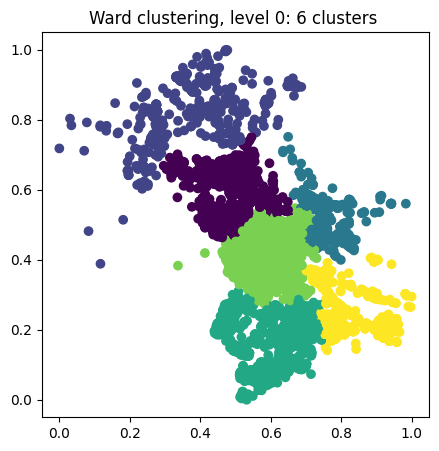

In [61]:
n_clusters = 6  
levels = 2

# We hierarchically distribute all points
top_down = linkage_matrix.top_down_view_recur(n_clusters, levels)
X = linkage_matrix.data

fig, ax = plt.subplots()
fig.set_size_inches((5,5))

agg_labels = top_down[:,0] # level 0
ax.scatter(X.T[0], X.T[1], c=agg_labels)
ax.set_title(f'Ward clustering, level 0: {n_clusters} clusters ')
plt.show()

We can also see how each cluster in the previous figure is subsequently divided in N clusters. The tiny variations in hue indicate the different level-1 clusters

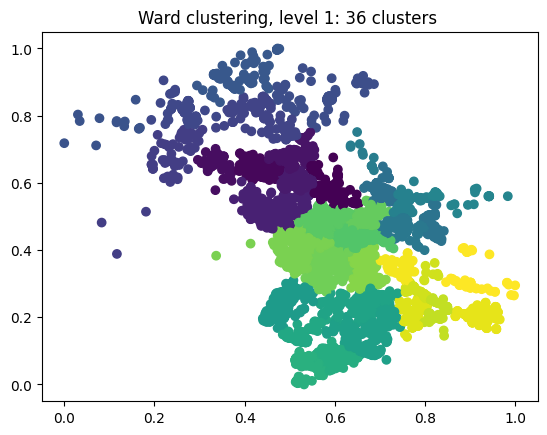

In [62]:
agg_labels = top_down[:,1]

fig, ax = plt.subplots()
ax.scatter(X.T[0], X.T[1], c=agg_labels)
ax.set_title(f'Ward clustering, level 1: {n_clusters*n_clusters} clusters ')
plt.show()

As our location for the bus trajectory, we will use the actual amenity closer to the centroid of 
each cluster centroid (per level as well). The result is presented in the next figure with red lines that
represent approximately the limits for level-0 clusters. The colors indicate level-1 clusters and the crosses the 
corresponding centroid locations.

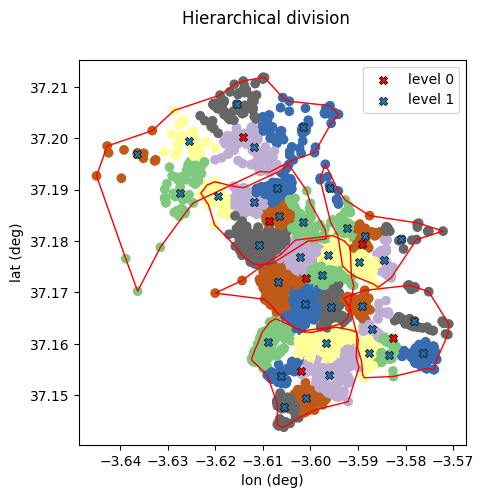

In [56]:
# fancy scatter
fig, ax = plt.subplots()
fig.set_size_inches((5,5))
X = np.array(linkage_matrix.data_lon_lat, dtype=np.float64)

ax.scatter(X[:,0], X[:,1], c=top_down[:,1]%10, cmap='Accent')
alpha_list = np.ones(n_clusters)*100

for i in range(1,n_clusters+1):
    cluster = X[top_down[:,0] == i]
    alpha = alpha_list[i-1]
    hull = alphashape.alphashape(cluster, alpha)
    if type(hull)== shapely.geometry.multipolygon.MultiPolygon:
        areas = [ geom.area for geom in hull.geoms]
        # Select the component with larger area
        big = np.argmax(areas)
        hull_pts = hull.geoms[big].exterior.coords.xy
    else:
        hull_pts = hull.exterior.coords.xy
    poly_patch = Polygon(np.array(hull_pts).T, facecolor='none', edgecolor='red')
    ax.add_patch(poly_patch)

centers =  linkage_matrix.give_centers_level(0)
plt.scatter(*centers.T, marker='X', edgecolors='black', color='red', linewidth=0.5, label='level 0')
centers =  linkage_matrix.give_centers_level(1)
plt.scatter(*centers.T, marker='X', edgecolors='black', linewidth=0.5, label='level 1')    
fig.suptitle('Hierarchical division')

plt.xlabel(r'lon (deg)')
plt.ylabel(r'lat (deg)')
plt.legend()
plt.show()


## 1.3. Locations in the map

Let's visualize the bus stops in their real geographical location. To do that, we use folium.

In [39]:
def map_show_array(data, labels, loc_coords, color, map=None):

  # Create a map centered on loc_coords [latitude, longitude]
  if map == None:
      map = folium.Map(location=loc_coords, zoom_start=12)

  # Loop through the data and add markers for each location
  for i in range(len(data)):
      folium.Marker([data[i][1], data[i][0]],
                    popup=labels[i], icon=folium.Icon(color=color) ).add_to(map)
  return map

centers_0 =  linkage_matrix.give_centers_level(0)
means = centers_0.mean(axis=0)
means_lat_lon = [means[1], means[0]]
labels_0 = range(1, len(centers_0) + 1)
map = map_show_array(centers_0, labels, means_lat_lon, 'red')

centers_1 =  linkage_matrix.give_centers_level(1)
means = centers_1.mean(axis=0)
means_lat_lon = [means[1], means[0]]
labels = [ int(str(i) + str(j)) for i in labels_0 for j in labels_0] 
print(labels)
map_show_array(centers_1, labels, means_lat_lon, 'blue', map)



[11, 12, 13, 14, 15, 16, 21, 22, 23, 24, 25, 26, 31, 32, 33, 34, 35, 36, 41, 42, 43, 44, 45, 46, 51, 52, 53, 54, 55, 56, 61, 62, 63, 64, 65, 66]


# 2. Solve with QUBOSolver

In [13]:
#HERE EXECUTE QUBOSOLVER

## 2.1 Visualize QUBOSolver

In [15]:
def draw_line(df, line, color, map=None):
    means = df.mean()
    loc_coords = [means.iloc[1], means.iloc[2]]
    if map == None:
        map = folium.Map(location=loc_coords, zoom_start=8)
    # Get all connected positions from line adj matrix
    nonzero = np.nonzero(line)
    for i in range(len(nonzero[0])):
        indx1 = nonzero[0][i]
        indx2 = nonzero[1][i]

        pos_1 = df.iloc[indx1][['lat','lon']].values
        pos_2 = df.iloc[indx2][['lat','lon']].values
        folium.Marker(pos_1).add_to(map)
        folium.Marker(pos_2).add_to(map)
        colorline = folium.features.PolyLine([pos_1,pos_2], color=color)
        colorline.add_to(map)
    return map
line = np.genfromtxt(os.path.join("results", 'Line0.dat'))
map = draw_line(final_data, line, 'red')
line = np.genfromtxt(os.path.join("results", 'Line1.dat'))
map = draw_line(final_data, line, 'blue', map)
line = np.genfromtxt(os.path.join("results", 'Line2.dat'))
map = draw_line(final_data, line, 'green', map)
map

FileNotFoundError: results/Line0.dat not found.

In [226]:
def sample_data(df, labels, n_sampled_stops, seed = 140421):
  np.random.seed(seed)
  # We extract n samples from each cluster
  unique_labels = np.unique(labels)
  # first position is reserved for nonassigned data
  n_cluster = np.zeros(len(unique_labels))
  indices = np.indices(labels.shape)[0]
  cluster_indices = []
  max_cluster_size = int(n_sampled_stops/len(unique_labels))

  sample_indx = []

  for i in range(len(unique_labels)):
    filter_labels = labels == unique_labels[i]
    cluster_indices = indices[filter_labels]
    n_cluster[i] = len(cluster_indices)

    # Now we sample max_cluster_size
    extract_size = np.amin([max_cluster_size, n_cluster[i]]).astype(int)
    sample_indx.extend(np.random.choice(cluster_indices, size=extract_size, replace=False))
  final_data = pd.DataFrame(df.to_numpy()[sample_indx], columns=['id', 'lat', 'lon', 'index'])
  return final_data

# Since calculating driving distances is a costly process, we sample the data to obtain 
# something manageable
labels = top_down[:,0]
df['index'] = range(1, len(df) + 1)
n_sampled_stops = 100
final_data = sample_data(df, labels, n_sampled_stops)
print(final_data)

             id         lat         lon index
0    9786022817  37.1852606  -3.6047226  2992
1    6257690490  37.1779723  -3.6091317  1522
2    5810941447  37.1828105  -3.6019722   974
3    9673893920  37.1834345  -3.6023575  2872
4    9853127397  37.1793766  -3.6128016  2999
..          ...         ...         ...   ...
91   9585645197  37.1581967  -3.5851486  2790
92  11160284862  37.1556491  -3.5868738  4438
93  12533825415  37.1621265  -3.5858205  5126
94   1919749250  37.1662076  -3.5836536   205
95  11918174734  37.1568356  -3.5760317  4769

[96 rows x 4 columns]
